<a href="https://colab.research.google.com/github/Amir-D-Shadow/Google-Colab/blob/main/tensorflow_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.utils import plot_model

In [69]:
x = tf.constant(value=np.arange(1,5).reshape(1,2,2,1))
x = tf.keras.layers.Input(shape=(2,2,1))
y = tf.keras.layers.UpSampling2D(size=2,interpolation="bilinear")(x)
print(type(tf.slice(y,[0,0,0,0],[1,4,4,1])))
print(type(y[0,:,:,0]))
print(type(y))
print(type(type(y.get_shape()[1])))
a = type(y.get_shape()[1])
a = type((2,))
         
if a.__name__ == "int":

  print("int")

elif a.__name__ == "tuple":

  print("tuple")



<class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>
<class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>
<class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>
<class 'type'>
tuple


In [70]:
x = tf.keras.layers.Input(shape=(6,6,32))
y1 = tf.keras.layers.UpSampling2D(size=2,interpolation="bilinear",data_format = "channels_last")(x)
k = tf.keras.layers.Conv2DTranspose(32,4,1)(y1)
y2 = tf.keras.layers.UpSampling2D(size=2,interpolation="nearest",data_format = "channels_last")(x)

a = tf.keras.layers.concatenate([y1,y2])[tf.newaxis,:,:,:,:]
b = tf.keras.layers.concatenate([y1,y2])
type(a)
type(b)
print(y1.shape)
print(k.shape)

(None, 12, 12, 32)
(None, 15, 15, 32)


In [116]:
#TCBL Module
class TCBL(tf.keras.Model):

   def __init__(self,filters=32,kernel_size=3,strides=1,padding="valid",**kwargs):

      #initialization
      super(TCBL,self).__init__(**kwargs)

      #define layers
      self.conv2D_transpose_x = tf.keras.layers.Conv2DTranspose(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,data_format="channels_last")

      self.BN_x = tf.keras.layers.BatchNormalization(axis=-1)

      self.output_leaky_relu = tf.keras.layers.LeakyReLU()

      

   def call(self,inputs):

      """
      input -- tensorflow layer with shape (m,n_H,n_W,n_C)
      """

      #Transpose Convolution 2D layer
      conv2D_transpose_x = self.conv2D_transpose_x(inputs)

      #Batch Normalization layer
      BN_x = self.BN_x(conv2D_transpose_x)

      #activate by Mish
      output_leaky_relu = self.output_leaky_relu(BN_x)

      return output_leaky_relu

   def graph_model(self,dim):

      x = tf.keras.layers.Input(shape=dim)
      
      return tf.keras.Model(inputs=x,outputs=self.call(x))

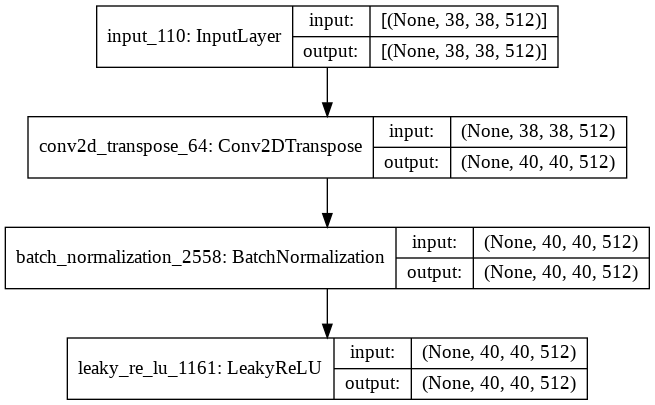

In [117]:
initializer = tf.random_normal_initializer()
k = tf.Variable(initial_value=initializer(shape=(10,38,38,512),dtype="float32"))
in_x = tf.keras.layers.Input(shape=tuple(k.get_shape().as_list()[1:]))

y = TCBL(512,3,1,"valid")
model = y.graph_model(tuple(in_x.get_shape().as_list()[1:]))
plot_model(model,show_shapes=True, show_layer_names=True)

In [71]:
class SpatialSlicing(tf.keras.layers.Layer):

   def __init__(self,kernel_size,strides=1,**kwargs):

      """
      tuple : (H,W,C)
      """

      #initialization
      super(SpatialSlicing,self).__init__(**kwargs)

      #set up
      self.identity_kernel = tf.ones(shape = kernel_size)

      self.fH = kernel_size[0]
      self.fW = kernel_size[1]

      self.strides = strides


   def call(self,inputs):
      
      #get input shape
      m,IMG_H,IMG_W,IMG_C = inputs.get_shape().as_list()

      #calculate nH,nW
      nH = int((IMG_H-self.fH)/self.strides) + 1
      nW = int((IMG_W-self.fW)/self.strides) + 1

      #layer
      layer_list = []

      #slicing
      for i in range(m):

         sample_list = []

         for h in range(nH):

            imgh_start = h*self.strides
            imgh_end = imgh_start + self.fH

            for w in range(nW):

               imgw_start = w*self.strides
               imgw_end = imgw_start + self.fW
               #print(self.identity_kernel.get_shape())
               #print(inputs[i,imgh_start:imgh_end,imgw_start:imgw_end,:])
               tmp = tf.keras.layers.Multiply()([self.identity_kernel,inputs[i,imgh_start:imgh_end,imgw_start:imgw_end,:]])
               
               sample_list.append(tmp )

         #element in sample list has shape -- (fH,fW,IMG_C) , ouput -- (1,fH,fW,IMG_C)
         layer_list.append(tf.keras.layers.concatenate(inputs = sample_list,axis=-1)[tf.newaxis,:,:,:])

                                        
      #result
      output_concat = tf.keras.layers.concatenate(inputs = layer_list,axis=0)

      return output_concat

In [72]:
initializer = tf.random_normal_initializer()
k = tf.Variable(initial_value=initializer(shape=(10,20,20,128),dtype="float64"))
in_x = tf.keras.layers.Input(shape=tuple(k.get_shape().as_list()[1:]))
x = tf.Variable(initial_value=initializer(shape=(10,10,128),dtype="float64"))

k1 = SpatialSlicing(tuple(x.get_shape().as_list()))(k)
k1.get_shape()

TensorShape([10, 10, 10, 15488])

In [73]:
class CBL(tf.keras.Model):

   def __init__(self,filters=32,kernel_size=3,strides=2,padding='valid',**kwargs):

      #initialization
      super(CBL,self).__init__(**kwargs)

      #define layers
      self.conv2D_x = tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding)

      self.BN_x = tf.keras.layers.BatchNormalization(axis=3)

      self.output_leaky_relu = tf.keras.layers.LeakyReLU()
      

   def call(self,inputs):

      """
      input -- tensorflow layer with shape (m,n_H,n_W,n_C)
      """

      #convolution layer
      conv2D_x = self.conv2D_x(inputs)

      #Batch Normalization layer
      BN_x = self.BN_x(conv2D_x)

      #activate by Leaky relu
      output_leaky_relu = self.output_leaky_relu(BN_x)

      return output_leaky_relu

   def graph_model(self,dim):

      x = tf.keras.layers.Input(shape=dim)
      
      return tf.keras.Model(inputs=x,outputs=self.call(x))

In [74]:
#activation Mish
def Mish(x):

   softplus = tf.math.softplus(x)
   tanh_s = tf.math.tanh(softplus)

   return (x * tanh_s)


#CBM Module
class CBM(tf.keras.Model):

   def __init__(self,filters=32,kernel_size=3,strides=2,padding="valid",**kwargs):

      #initialization
      super(CBM,self).__init__(**kwargs)

      #define layers
      self.conv2D_x = tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding)

      self.BN_x = tf.keras.layers.BatchNormalization(axis=3)

      self.output_Mish = tf.keras.layers.Lambda(Mish,name="Mish")

      

   def call(self,inputs):

      """
      input -- tensorflow layer with shape (m,n_H,n_W,n_C)
      """

      #Convolution 2D layer
      conv2D_x = self.conv2D_x(inputs)

      #Batch Normalization layer
      BN_x = self.BN_x(conv2D_x)

      #activate by Mish
      output_Mish = self.output_Mish(BN_x)

      return output_Mish

   def graph_model(self,dim):

      x = tf.keras.layers.Input(shape=dim)
      
      return tf.keras.Model(inputs=x,outputs=self.call(x))

In [75]:
class SPP(tf.keras.Model):

   def __init__(self,**kwargs):

      #initialization
      super(SPP,self).__init__(**kwargs)

      #define layers
      self.maxpool_5x5 = tf.keras.layers.MaxPooling2D(pool_size=5,strides=1,padding="same")

      self.maxpool_9x9 = tf.keras.layers.MaxPooling2D(pool_size=9,strides=1,padding="same")

      self.maxpool_13x13 = tf.keras.layers.MaxPooling2D(pool_size=13,strides=1,padding="same")


   def call(self,inputs):

      """
      input -- tensorflow layer with shape (m,n_H,n_W,n_C)
      """
      
      #5x5
      maxpool_5x5 = self.maxpool_5x5(inputs)

      #9x9
      maxpool_9x9 = self.maxpool_9x9(inputs)

      #13x13
      maxpool_13x13 = self.maxpool_13x13(inputs)

      #concatenate
      output_concat = tf.keras.layers.concatenate(inputs=[maxpool_5x5,maxpool_9x9,maxpool_13x13,inputs],axis=3)

      return output_concat

   def graph_model(self,dim):

      x = tf.keras.layers.Input(shape=dim)
      
      return tf.keras.Model(inputs=x,outputs=self.call(x))

In [76]:
class res_unit(tf.keras.Model):

   def graph_model(self,dim):

      x = tf.keras.layers.Input(shape=dim)
      
      return tf.keras.Model(inputs=x,outputs=self.call(x))

   def __init__(self,block_info,**kwargs):

      """
      block_info -- dictionary containing blocks' hyperparameters (filters,kernel_size,strides,padding)

      Module Graph:

      ------ CBM_1 ------ CBM_2 ------ Add
         |                              |
         |                              |
         |                              |
         --------------------------------

      
      """

      #initialization
      super(res_unit,self).__init__(**kwargs)
      
      #1st CBM block
      filters,kernel_size,strides,padding = block_info["CBM_1"]
      
      self.CBM_1 = CBM(filters,kernel_size,strides,padding)

      #2nd CBM block
      filters,kernel_size,strides,padding = block_info["CBM_2"]

      self.CBM_2 = CBM(filters,kernel_size,strides,padding)

      #Add Layer
      self.Add_layer = tf.keras.layers.Add()


   def call(self,inputs):

      x = inputs

      #1st CBM block
      CBM_1 = self.CBM_1(inputs)

      #2nd CBM block
      CBM_2 = self.CBM_2(CBM_1)

      #Add Layer
      output_shortcut = self.Add_layer([CBM_2,x])

      return output_shortcut


In [77]:
#Backbone CSPX
class CSPX(tf.keras.Model):

   def __init__(self,CSPX_info,**kwargs):

      """
      CSPX_info -- dictionary containing information: num_of_res_unit , res_unit block info , CBM block info , CBL_info

                     - hpara: (filters,kernel_size,strides,padding)

                     
      Module Graph:
      
      ------ CBL_1 ------ CBL_2 ------ res_unit * X ------ CBL_3 -----
                     |                                               |
                     |                                               |______
                     |                                                ______  Concat --- BN --- leaky relu --- CBM_1 
                     |                                               |
                     |                                               |
                     -------------------------------- CBL_4 ----------
      """

      #initialization
      super(CSPX,self).__init__(**kwargs)

      #extract num_of_res_unit
      self.num_of_res_unit = CSPX_info["num_of_res_unit"]

      #define layers

      #res_unit
      self.res_unit_seq = {}

      #Important: When defining the CSPX layer, remember to define res unit info (dictionary key) in the form of res_unit_i : i start from 1
      for i in range(1,self.num_of_res_unit+1):

         #Extract res_unit_i info
         res_unit_info = CSPX_info[f"res_unit_{i}"]

         #define resunit layer
         self.res_unit_seq[f"res_unit_{i}"] = res_unit(res_unit_info)
         

      #CBL_1
      filters,kernel_size,strides,padding = CSPX_info["CBL_1"]
      
      self.CBL_1 = CBL(filters,kernel_size,strides,padding)

      #CBL_2
      filters,kernel_size,strides,padding = CSPX_info["CBL_2"]
      
      self.CBL_2 = CBL(filters,kernel_size,strides,padding)

      #CBL_3
      filters,kernel_size,strides,padding = CSPX_info["CBL_3"]
      
      self.CBL_3 = CBL(filters,kernel_size,strides,padding)

      #CBL_4
      filters,kernel_size,strides,padding = CSPX_info["CBL_4"]
      
      self.CBL_4 = CBL(filters,kernel_size,strides,padding)

      #BN
      self.BN_x = tf.keras.layers.BatchNormalization(axis=-1)

      #leaky relu
      self.leaky_relu_x = tf.keras.layers.LeakyReLU()

      #CBM_1
      filters,kernel_size,strides,padding = CSPX_info["CBM_1"]

      self.CBM_1 = CBM(filters,kernel_size,strides,padding)
      

   def call(self,inputs):

      """
      input -- tensorflow layer with shape (m,n_H,n_W,n_C)
      """

      x = inputs

      #CBL_1
      CBL_1 = self.CBL_1(x)

      #CBL_2
      CBL_2 = self.CBL_2(CBL_1)

      #res_unit block
      res_unit_block = CBL_2
      
      for i in range(1,self.num_of_res_unit+1):

         res_unit_block =  (self.res_unit_seq[f"res_unit_{i}"])(res_unit_block) 

      #CBL3
      CBL_3 = self.CBL_3(res_unit_block)
      
      #CBL_4
      CBL_4 = self.CBL_4(CBL_1)

      #Concat
      mid_concat = tf.keras.layers.concatenate(inputs=[CBL_3,CBL_4],axis=-1)

      #Batch Normalization
      BN_x = self.BN_x(mid_concat)

      #leaky_relu_x
      leaky_relu_x = self.leaky_relu_x(BN_x)

      #output_CBM
      output_CBM = self.CBM_1(leaky_relu_x)

      return output_CBM

   def graph_model(self,dim):

      x = tf.keras.layers.Input(shape=dim)
        
      return tf.keras.Model(inputs=x,outputs=self.call(x))


In [78]:
#revised CSPX
class rCSP(tf.keras.Model):


   def __init__(self,rCSP_info,**kwargs):

      """
      rCSP_info -- dictionary containing information:  CBL info 

                     - hpara: (filters,kernel_size,strides,padding)

                     
      Module Graph:
      
                   ------- CBL_2 --- CBL_3 --- CBL_4 --- SPP_1 --- CBL_5 -----
                   |                                                         |
                   |                                                         |______
         CBL_1  ---|                                                          ______  Concat --- CBL_7
                   |                                                         |
                   |                                                         |
                   --------------------------- CBL_6 -------------------------
         
      """
      #initialization
      super(rCSP,self).__init__(**kwargs)

      #CBL_1
      filters,kernel_size,strides,padding = rCSP_info["CBL_1"]
      
      self.CBL_1 = CBL(filters,kernel_size,strides,padding)
      
      #CBL_2
      filters,kernel_size,strides,padding = rCSP_info["CBL_2"]

      self.CBL_2 = CBL(filters,kernel_size,strides,padding)

      #CBL_3
      filters,kernel_size,strides,padding = rCSP_info["CBL_3"]

      self.CBL_3 = CBL(filters,kernel_size,strides,padding)

      #CBL_4
      filters,kernel_size,strides,padding = rCSP_info["CBL_4"]

      self.CBL_4 = CBL(filters,kernel_size,strides,padding)     

      #SPP
      self.SPP_1 = SPP()

      #CBL_5
      filters,kernel_size,strides,padding = rCSP_info["CBL_5"]

      self.CBL_5 = CBL(filters,kernel_size,strides,padding)

      #CBL_6
      filters,kernel_size,strides,padding = rCSP_info["CBL_6"]

      self.CBL_6 = CBL(filters,kernel_size,strides,padding)

      #CBL_7
      filters,kernel_size,strides,padding = rCSP_info["CBL_7"]

      self.CBL_7 = CBL(filters,kernel_size,strides,padding)
      
   def call(self,inputs):

      """
      input -- tensorflow layer with shape (m,n_H,n_W,n_C)
      """

      #CBL_1
      CBL_1 = self.CBL_1(inputs)

      #CBL_2
      CBL_2 = self.CBL_2(CBL_1)

      #CBL_3
      CBL_3 = self.CBL_3(CBL_2)

      #CBL_4
      CBL_4 = self.CBL_4(CBL_3)

      #SPP_1
      SPP_1 = self.SPP_1(CBL_4)

      #CBL_5
      CBL_5 = self.CBL_5(SPP_1)

      #CBL_6
      CBL_6 = self.CBL_6(CBL_1)

      #concat
      mid_concat = tf.keras.layers.concatenate(inputs=[CBL_6,CBL_5],axis=-1)

      #CBL_7
      output_CBL_7 = self.CBL_7(mid_concat)
  
      
      return output_CBL_7

    
   def graph_model(self,dim):

      x = tf.keras.layers.Input(shape=dim)
        
      return tf.keras.Model(inputs=x,outputs=self.call(x))

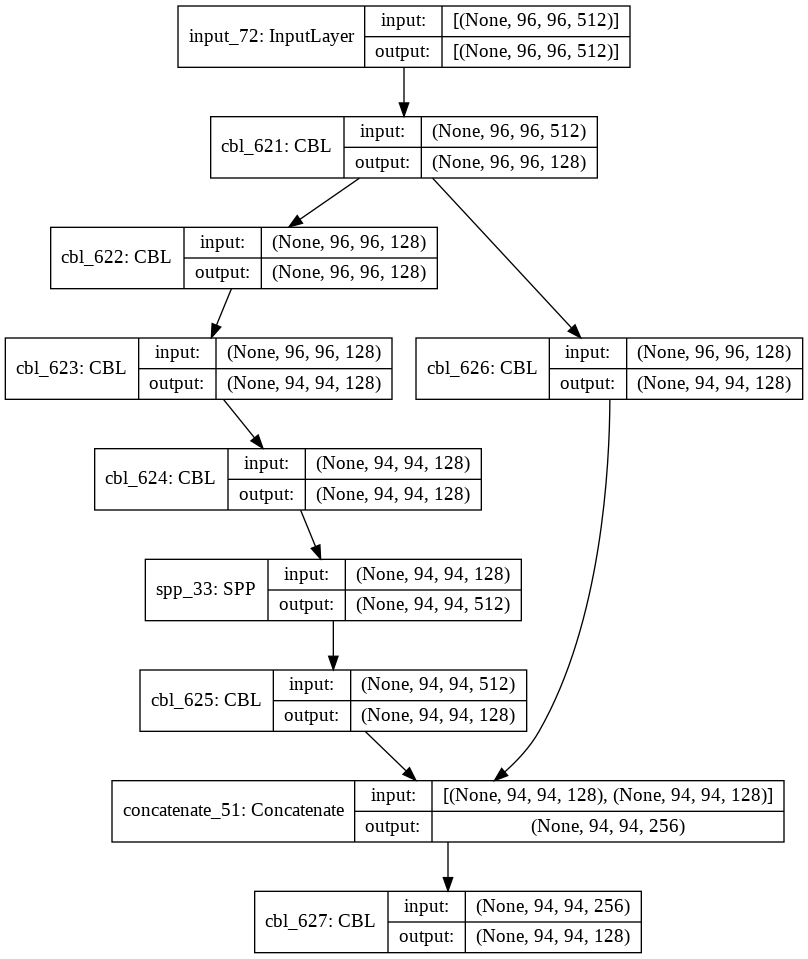

In [79]:
rCSP_info = {}

rCSP_info["CBL_1"] = (128,3,1,"same")
rCSP_info["CBL_2"] = (128,3,1,"same")
rCSP_info["CBL_3"] = (128,3,1,"valid")
rCSP_info["CBL_4"] = (128,3,1,"same")
rCSP_info["CBL_5"] = (128,3,1,"same")
rCSP_info["CBL_6"] = (128,3,1,"valid")
rCSP_info["CBL_7"] = (128,3,1,"same")

initializer = tf.random_normal_initializer()
k = tf.Variable(initial_value=initializer(shape=(10,96,96,512),dtype="float64"))
in_x = tf.keras.layers.Input(shape=tuple(k.get_shape().as_list()[1:]))

y = rCSP(rCSP_info)
model = y.graph_model(tuple(in_x.get_shape().as_list()[1:]))
plot_model(model,show_shapes=True, show_layer_names=True)

In [80]:
#Neck CSPX
class CSPX_Neck(tf.keras.Model):

   def __init__(self,NECK_info,**kwargs):
      
      """
      NECK_info -- dictionary containing information: num_of_CBL, CBM block info , CBL block info , conv2D info

                     - hpara: (filters,kernel_size,strides,padding)

                     
      Module Graph:
      
      ----------- CBL * X ------ conv2D_1 ----------------
         |                                               |
         |                                               |______
         |                                                ______  Concat --- BN --- leaky relu --- CBM_1 
         |                                               |
         |                                               |
         -------------------------------- conv2D_2 -------
         
      """
      
      #initialization
      super(CSPX_Neck,self).__init__(**kwargs)

      #Get num_of_CBL
      self.num_of_CBL = NECK_info["num_of_CBL"]

      #define layers

      #CBL_X
      self.CBL_seq = {}

      for i in range(1,self.num_of_CBL+1):

         filters,kernel_size,strides,padding = NECK_info[f"CBL_{i}"]

         self.CBL_seq[f"CBL_{i}"] = CBL(filters,kernel_size,strides,padding)


      #Conv2D_1
      filters,kernel_size,strides,padding = NECK_info["conv2D_1"]
      
      self.conv2D_1 = tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding)

      #conv2D_2
      filters,kernel_size,strides,padding = NECK_info["conv2D_2"]

      self.conv2D_2 = tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding)

      #Batch Normalization
      self.BN_x = tf.keras.layers.BatchNormalization(axis=3)
      
      #leaky relu
      self.leaky_relu_x = tf.keras.layers.LeakyReLU()

      #CBM_1
      filters,kernel_size,strides,padding = NECK_info["CBM_1"]

      self.CBM_1 = CBM(filters,kernel_size,strides,padding)


   def call(self,inputs):

      """
      input -- tensorflow layer with shape (m,n_H,n_W,n_C)
      """

      #CBL_X
      CBL_block = inputs
      
      for i in range(1,self.num_of_CBL+1):

         CBL_block = (self.CBL_seq[f"CBL_{i}"])(CBL_block)


      #conv2D_1
      conv2D_1 = self.conv2D_1(CBL_block)

      #conv2D_2
      conv2D_2 = self.conv2D_2(inputs)

      #concat
      mid_concat = tf.keras.layers.concatenate(inputs=[conv2D_1,conv2D_2],axis=3)

      #BN_x
      BN_x = self.BN_x(mid_concat)

      #leaky relu
      leaky_relu_x = self.leaky_relu_x(BN_x)

      #CBM_1
      output_CBM = self.CBM_1(leaky_relu_x)

      return output_CBM


   def graph_model(self,dim):

      x = tf.keras.layers.Input(shape=dim)
        
      return tf.keras.Model(inputs=x,outputs=self.call(x))

In [81]:
CSPX_info = {}

#num_of_res_unit
CSPX_info["num_of_res_unit"] = 4

#res_unit_info

res_unit_1 = {}
res_unit_1["CBM_1"] = (512,1,1,"same")
res_unit_1["CBM_2"] = (512,3,1,"same")
CSPX_info["res_unit_1"] = res_unit_1

res_unit_2 = {}
res_unit_2["CBM_1"] = (512,1,1,"same")
res_unit_2["CBM_2"] = (512,3,1,"same")
CSPX_info["res_unit_2"] = res_unit_2

res_unit_3 = {}
res_unit_3["CBM_1"] = (512,1,1,"same")
res_unit_3["CBM_2"] = (512,3,1,"same")
CSPX_info["res_unit_3"] = res_unit_3

res_unit_4 = {}
res_unit_4["CBM_1"] = (512,1,1,"same")
res_unit_4["CBM_2"] = (512,3,1,"same")
CSPX_info["res_unit_4"] = res_unit_4

#CBL_1
CSPX_info["CBL_1"] = (1024,3,2,"valid")

#CBL_2
CSPX_info["CBL_2"] = (512,1,1,"same")

#CBL_3
CSPX_info["CBL_3"] = (512,1,1,"same")

#CBL_4
CSPX_info["CBL_4"] = (512,1,1,"same")

#CBM_1
CSPX_info["CBM_1"] = (1024,1,1,"same")

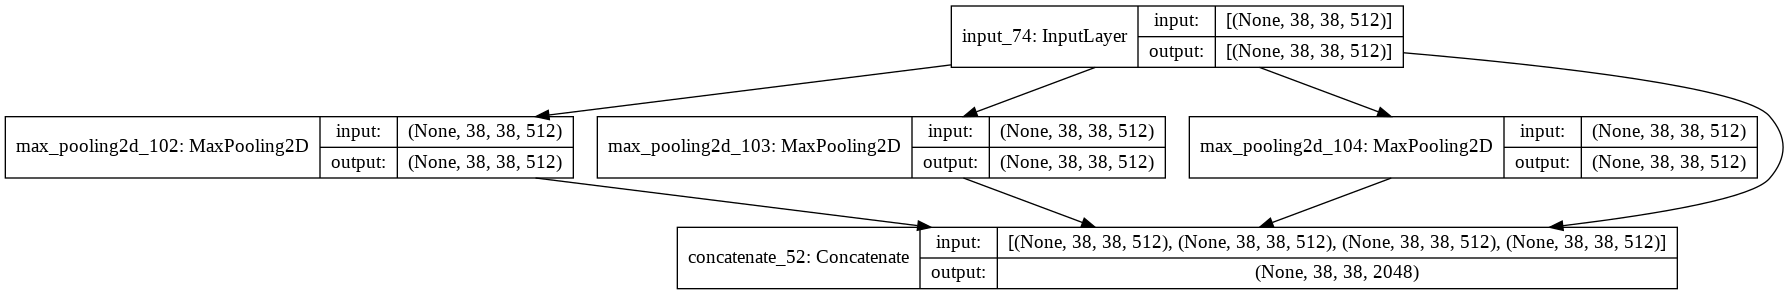

In [82]:
#SPP
initializer = tf.random_normal_initializer()
k = tf.Variable(initial_value=initializer(shape=(10,38,38,512),dtype="float32"))
in_x = tf.keras.layers.Input(shape=tuple(k.get_shape().as_list()[1:]))

y = SPP()
model = y.graph_model(tuple(in_x.get_shape().as_list()[1:]))
plot_model(model,show_shapes=True, show_layer_names=True)

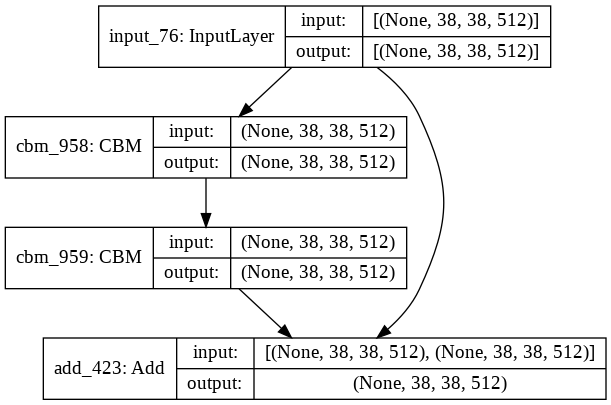

In [83]:
#res unit
initializer = tf.random_normal_initializer()
k = tf.Variable(initial_value=initializer(shape=(10,38,38,512),dtype="float32"))
in_x = tf.keras.layers.Input(shape=tuple(k.get_shape().as_list()[1:]))

y = res_unit(res_unit_1)
model = y.graph_model(tuple(in_x.get_shape().as_list()[1:]))
plot_model(model,show_shapes=True, show_layer_names=True)

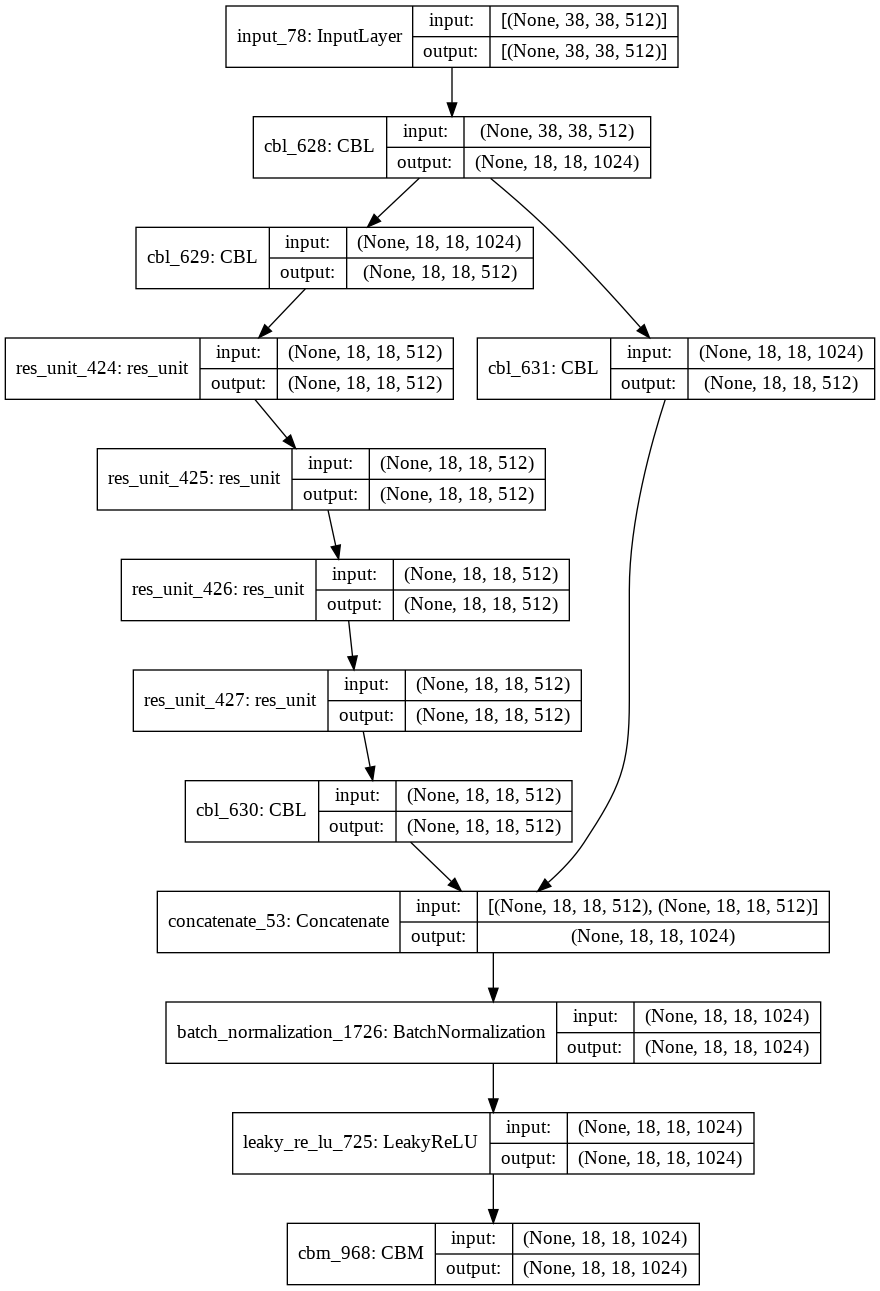

In [84]:
#CSPX
initializer = tf.random_normal_initializer()
k = tf.Variable(initial_value=initializer(shape=(10,38,38,512),dtype="float32"))
in_x = tf.keras.layers.Input(shape=tuple(k.get_shape().as_list()[1:]))

y = CSPX(CSPX_info)
model = y.graph_model(tuple(in_x.get_shape().as_list()[1:]))
plot_model(model,show_shapes=True, show_layer_names=True)

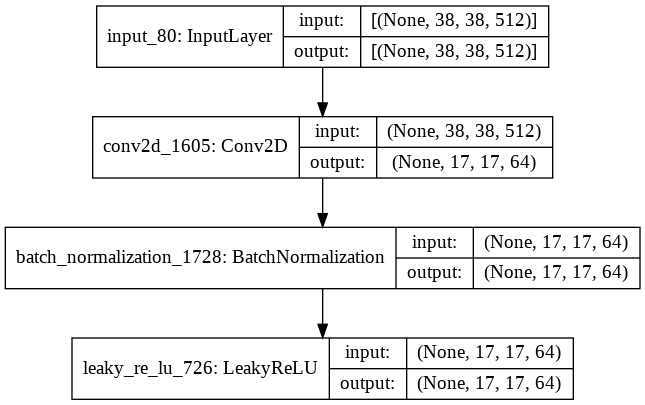

In [85]:
#CBL
initializer = tf.random_normal_initializer()
k = tf.Variable(initial_value=initializer(shape=(10,38,38,512),dtype="float32"))
in_x = tf.keras.layers.Input(shape=tuple(k.get_shape().as_list()[1:]))
filters,kernel_size,strides,padding = 64,6,2,"valid"

y = CBL(filters,kernel_size,strides,padding)
model = y.graph_model(tuple(in_x.get_shape().as_list()[1:]))
plot_model(model,show_shapes=True, show_layer_names=True)

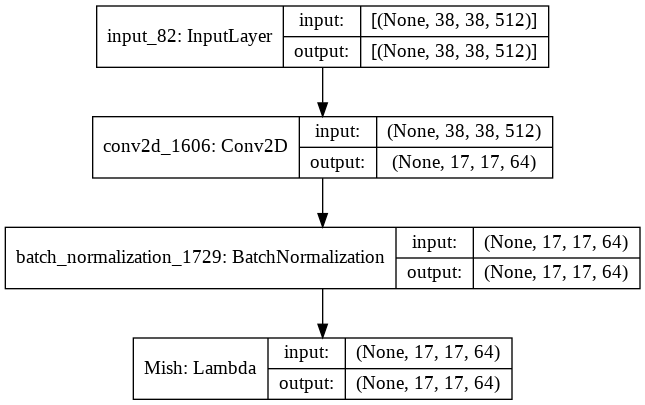

In [86]:
#CBM
initializer = tf.random_normal_initializer()
k = tf.Variable(initial_value=initializer(shape=(10,38,38,512),dtype="float32"))
in_x = tf.keras.layers.Input(shape=tuple(k.get_shape().as_list()[1:]))
filters,kernel_size,strides,padding = 64,6,2,"valid"

y = CBM(filters,kernel_size,strides,padding)
model = y.graph_model(tuple(in_x.get_shape().as_list()[1:]))
plot_model(model,show_shapes=True, show_layer_names=True)

In [87]:
NECK_info = {}

#num_of_CBL
NECK_info["num_of_CBL"] = 4

#CBL info
NECK_info["CBL_1"] = (512,1,1,"same")

NECK_info["CBL_2"] = (512,1,1,"same")

NECK_info["CBL_3"] = (512,3,1,"same")

NECK_info["CBL_4"] = (512,3,1,"same")

#conv2D
NECK_info["conv2D_1"] = (512,3,1,"same")
NECK_info["conv2D_2"] = (512,3,1,"same")

#CBM_1
NECK_info["CBM_1"] = (1024,1,1,"same")

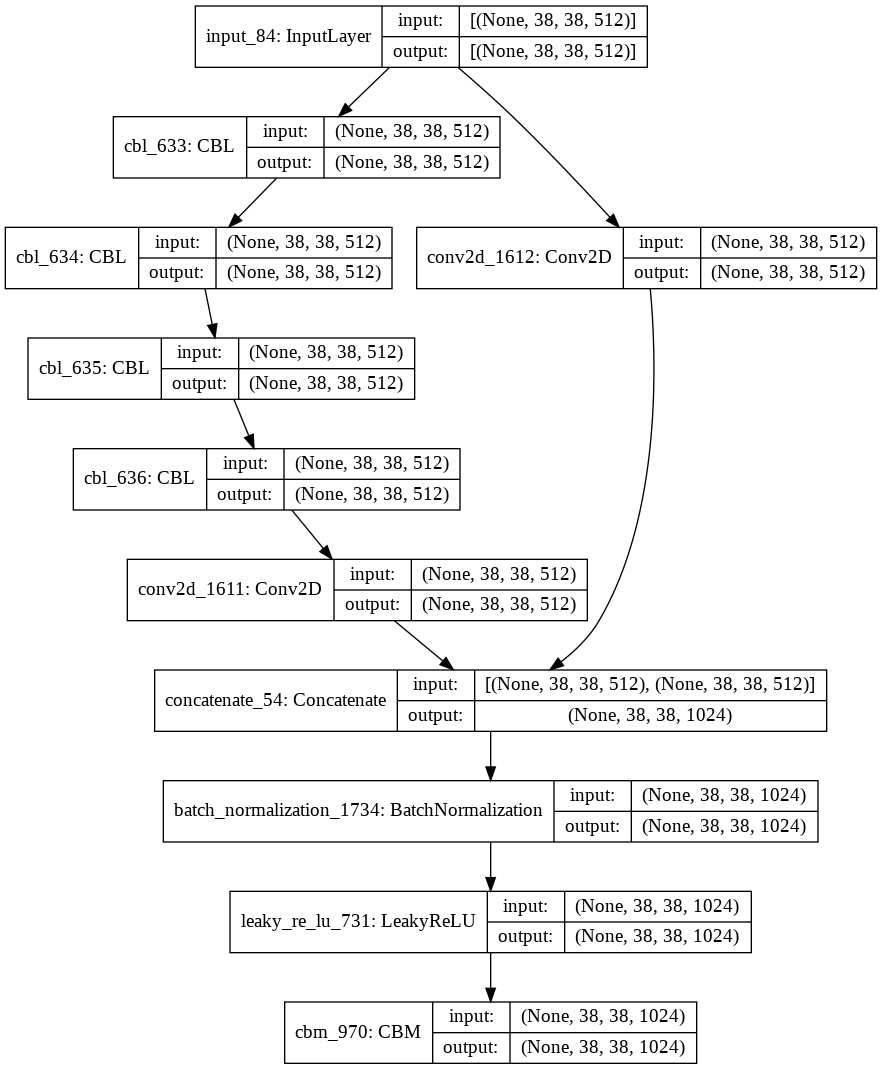

In [88]:
#NECK CSPX
initializer = tf.random_normal_initializer()
k = tf.Variable(initial_value=initializer(shape=(10,38,38,512),dtype="float32"))
in_x = tf.keras.layers.Input(shape=tuple(k.get_shape().as_list()[1:]))

y = CSPX_Neck(NECK_info)
model = y.graph_model(tuple(in_x.get_shape().as_list()[1:]))
plot_model(model,show_shapes=True, show_layer_names=True)

In [89]:
#activation Mish
def Mish(x):

   softplus = tf.math.softplus(x)
   tanh_s = tf.math.tanh(softplus)

   return (x * tanh_s)


#TCBM Module
class TCBM(tf.keras.Model):

   def __init__(self,filters=32,kernel_size=3,strides=1,padding="valid",**kwargs):

      #initialization
      super(TCBM,self).__init__(**kwargs)

      #define layers
      self.conv2D_transpose_x = tf.keras.layers.Conv2DTranspose(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,data_format="channels_last")

      self.BN_x = tf.keras.layers.BatchNormalization(axis=-1)

      self.output_Mish = tf.keras.layers.Lambda(Mish)

      

   def call(self,inputs):

      """
      input -- tensorflow layer with shape (m,n_H,n_W,n_C)
      """

      #Transpose Convolution 2D layer
      conv2D_transpose_x = self.conv2D_transpose_x(inputs)

      #Batch Normalization layer
      BN_x = self.BN_x(conv2D_transpose_x)

      #activate by Mish
      output_Mish = self.output_Mish(BN_x)

      return output_Mish

   def graph_model(self,dim):

      x = tf.keras.layers.Input(shape=dim)
        
      return tf.keras.Model(inputs=x,outputs=self.call(x))

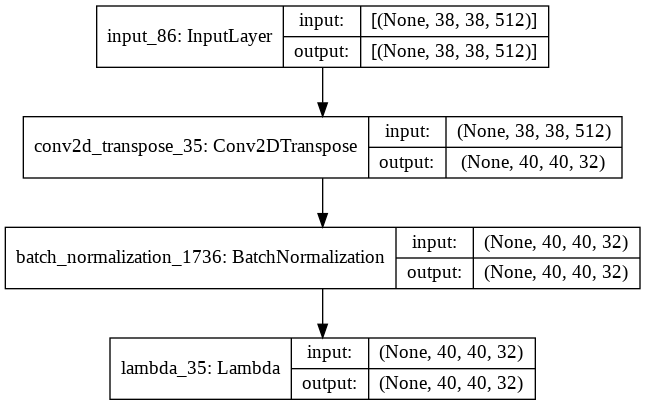

In [90]:
initializer = tf.random_normal_initializer()
k = tf.Variable(initial_value=initializer(shape=(10,38,38,512),dtype="float32"))
in_x = tf.keras.layers.Input(shape=tuple(k.get_shape().as_list()[1:]))

y = TCBM()
model = y.graph_model(tuple(in_x.get_shape().as_list()[1:]))
plot_model(model,show_shapes=True, show_layer_names=True)

In [135]:
class alpha_model(tf.keras.Model):

   def __init__(self,**kwargs):

      #initialization
      super(alpha_model,self).__init__(**kwargs)

      #CBM_1 in : 640 x 640 x 3 out: 640 x 640 x 32
      filters=32
      kernel_size=3
      strides=1
      padding="same"
      
      self.CBM_1 = CBM(filters,kernel_size,strides,padding)

      #----------------------------------------------------------------

      #CSP1 in : 640 x 640 x 32 out : 319 x 319 x 64
      CSPX_info = {}

      #num_of_res_unit
      CSPX_info["num_of_res_unit"] = 1

      #res_unit_info

      res_unit_1 = {}
      res_unit_1["CBM_1"] = (32,1,1,"same")
      res_unit_1["CBM_2"] = (64,3,1,"same")
      CSPX_info["res_unit_1"] = res_unit_1


      #CBL_1
      CSPX_info["CBL_1"] = (64,3,2,"valid")

      #CBL_2
      CSPX_info["CBL_2"] = (64,1,1,"same")

      #CBL_3
      CSPX_info["CBL_3"] = (64,3,1,"same")

      #CBL_4
      CSPX_info["CBL_4"] = (64,3,1,"same")

      #CBM_1
      CSPX_info["CBM_1"] = (64,1,1,"same")

      #define CSP1
      self.CSP1 = CSPX(CSPX_info)

      #----------------------------------------------------------------

      #CSP2 in : 319 x 319 x 32 out : 159 x 159 x 128
      CSPX_info = {}

      #num_of_res_unit
      CSPX_info["num_of_res_unit"] = 2

      #res_unit_info

      res_unit_1 = {}
      res_unit_1["CBM_1"] = (64,1,1,"same")
      res_unit_1["CBM_2"] = (64,3,1,"same")
      CSPX_info["res_unit_1"] = res_unit_1

      res_unit_2 = {}
      res_unit_2["CBM_1"] = (64,1,1,"same")
      res_unit_2["CBM_2"] = (64,3,1,"same")
      CSPX_info["res_unit_2"] = res_unit_2


      #CBL_1
      CSPX_info["CBL_1"] = (128,3,2,"valid")

      #CBL_2
      CSPX_info["CBL_2"] = (64,1,1,"same")

      #CBL_3
      CSPX_info["CBL_3"] = (64,3,1,"same")

      #CBL_4
      CSPX_info["CBL_4"] = (64,3,1,"same")

      #CBM_1
      CSPX_info["CBM_1"] = (128,1,1,"same")

      #define CSP2
      self.CSP2 = CSPX(CSPX_info)

      #----------------------------------------------------------------

      #CSP8_1 in : 159 x 159 x 128 out : 79 x 79 x 256
      CSPX_info = {}

      #num_of_res_unit
      CSPX_info["num_of_res_unit"] = 8

      #res_unit_info

      res_unit_1 = {}
      res_unit_1["CBM_1"] = (128,1,1,"same")
      res_unit_1["CBM_2"] = (128,3,1,"same")
      CSPX_info["res_unit_1"] = res_unit_1

      res_unit_2 = {}
      res_unit_2["CBM_1"] = (128,1,1,"same")
      res_unit_2["CBM_2"] = (128,3,1,"same")
      CSPX_info["res_unit_2"] = res_unit_2

      res_unit_3 = {}
      res_unit_3["CBM_1"] = (128,1,1,"same")
      res_unit_3["CBM_2"] = (128,3,1,"same")
      CSPX_info["res_unit_3"] = res_unit_3

      res_unit_4 = {}
      res_unit_4["CBM_1"] = (128,1,1,"same")
      res_unit_4["CBM_2"] = (128,3,1,"same")
      CSPX_info["res_unit_4"] = res_unit_4

      res_unit_5 = {}
      res_unit_5["CBM_1"] = (128,1,1,"same")
      res_unit_5["CBM_2"] = (128,3,1,"same")
      CSPX_info["res_unit_5"] = res_unit_5

      res_unit_6 = {}
      res_unit_6["CBM_1"] = (128,1,1,"same")
      res_unit_6["CBM_2"] = (128,3,1,"same")
      CSPX_info["res_unit_6"] = res_unit_6

      res_unit_7 = {}
      res_unit_7["CBM_1"] = (128,1,1,"same")
      res_unit_7["CBM_2"] = (128,3,1,"same")
      CSPX_info["res_unit_7"] = res_unit_7

      res_unit_8 = {}
      res_unit_8["CBM_1"] = (128,1,1,"same")
      res_unit_8["CBM_2"] = (128,3,1,"same")
      CSPX_info["res_unit_8"] = res_unit_8



      #CBL_1
      CSPX_info["CBL_1"] = (256,3,2,"valid")

      #CBL_2
      CSPX_info["CBL_2"] = (128,1,1,"same")

      #CBL_3
      CSPX_info["CBL_3"] = (128,3,1,"same")

      #CBL_4
      CSPX_info["CBL_4"] = (128,3,1,"same")

      #CBM_1
      CSPX_info["CBM_1"] = (256,1,1,"same")

      #define CSP8_1
      self.CSP8_1 = CSPX(CSPX_info)

      #----------------------------------------------------------------

      #spatialdropout_1 in : 79 x 79 x 256 out : 79 x 79 x 256 , ( branch 1 -- out : 79 x 79 x 256 )
      self.SPA_drop_1 = tf.keras.layers.SpatialDropout2D(rate = 0.5,data_format="channels_last")

      #----------------------------------------------------------------

      #CSP8_2 in : 79 x 79 x 256 out : 39 x 39 x 512
      CSPX_info = {}

      #num_of_res_unit
      CSPX_info["num_of_res_unit"] = 8

      #res_unit_info

      res_unit_1 = {}
      res_unit_1["CBM_1"] = (256,1,1,"same")
      res_unit_1["CBM_2"] = (256,3,1,"same")
      CSPX_info["res_unit_1"] = res_unit_1

      res_unit_2 = {}
      res_unit_2["CBM_1"] = (256,1,1,"same")
      res_unit_2["CBM_2"] = (256,3,1,"same")
      CSPX_info["res_unit_2"] = res_unit_2

      res_unit_3 = {}
      res_unit_3["CBM_1"] = (256,1,1,"same")
      res_unit_3["CBM_2"] = (256,3,1,"same")
      CSPX_info["res_unit_3"] = res_unit_3

      res_unit_4 = {}
      res_unit_4["CBM_1"] = (256,1,1,"same")
      res_unit_4["CBM_2"] = (256,3,1,"same")
      CSPX_info["res_unit_4"] = res_unit_4

      res_unit_5 = {}
      res_unit_5["CBM_1"] = (256,1,1,"same")
      res_unit_5["CBM_2"] = (256,3,1,"same")
      CSPX_info["res_unit_5"] = res_unit_5

      res_unit_6 = {}
      res_unit_6["CBM_1"] = (256,1,1,"same")
      res_unit_6["CBM_2"] = (256,3,1,"same")
      CSPX_info["res_unit_6"] = res_unit_6

      res_unit_7 = {}
      res_unit_7["CBM_1"] = (256,1,1,"same")
      res_unit_7["CBM_2"] = (256,3,1,"same")
      CSPX_info["res_unit_7"] = res_unit_7

      res_unit_8 = {}
      res_unit_8["CBM_1"] = (256,1,1,"same")
      res_unit_8["CBM_2"] = (256,3,1,"same")
      CSPX_info["res_unit_8"] = res_unit_8



      #CBL_1
      CSPX_info["CBL_1"] = (512,3,2,"valid")

      #CBL_2
      CSPX_info["CBL_2"] = (256,1,1,"same")

      #CBL_3
      CSPX_info["CBL_3"] = (256,3,1,"same")

      #CBL_4
      CSPX_info["CBL_4"] = (256,3,1,"same")

      #CBM_1
      CSPX_info["CBM_1"] = (512,1,1,"same")

      #define CSP8_2
      self.CSP8_2 = CSPX(CSPX_info)

      #----------------------------------------------------------------

      #spatialdropout_2 in : 39 x 39 x 512 out : 39 x 39 x 512 , ( branch 2 -- out : 39 x 39 x 512 )
      self.SPA_drop_2 = tf.keras.layers.SpatialDropout2D(rate = 0.5,data_format="channels_last")

      #----------------------------------------------------------------

      #CSP4 in : 39 x 39 x 512 out : 19 x 19 x 1024
      CSPX_info = {}

      #num_of_res_unit
      CSPX_info["num_of_res_unit"] = 4

      #res_unit_info

      res_unit_1 = {}
      res_unit_1["CBM_1"] = (512,1,1,"same")
      res_unit_1["CBM_2"] = (512,3,1,"same")
      CSPX_info["res_unit_1"] = res_unit_1

      res_unit_2 = {}
      res_unit_2["CBM_1"] = (512,1,1,"same")
      res_unit_2["CBM_2"] = (512,3,1,"same")
      CSPX_info["res_unit_2"] = res_unit_2

      res_unit_3 = {}
      res_unit_3["CBM_1"] = (512,1,1,"same")
      res_unit_3["CBM_2"] = (512,3,1,"same")
      CSPX_info["res_unit_3"] = res_unit_3

      res_unit_4 = {}
      res_unit_4["CBM_1"] = (512,1,1,"same")
      res_unit_4["CBM_2"] = (512,3,1,"same")
      CSPX_info["res_unit_4"] = res_unit_4


      #CBL_1
      CSPX_info["CBL_1"] = (1024,3,2,"valid")

      #CBL_2
      CSPX_info["CBL_2"] = (512,1,1,"same")

      #CBL_3
      CSPX_info["CBL_3"] = (512,3,1,"same")

      #CBL_4
      CSPX_info["CBL_4"] = (512,3,1,"same")

      #CBM_1
      CSPX_info["CBM_1"] = (1024,1,1,"same")

      #define CSP4
      self.CSP4 = CSPX(CSPX_info)

      #----------------------------------------------------------------

      #spatialdropout_3 in : 19 x 19 x 1024  out : 19 x 19 x 1024
      self.SPA_drop_3 = tf.keras.layers.SpatialDropout2D(rate = 0.5,data_format="channels_last")

      #----------------------------------------------------------------

      #rCSP1 in : 19 x 19 x 1024 out : 19 x 19 x 512 , ( branch 3 -- out: 19 x 19 x 512 )
      rCSP_info = {}

      rCSP_info["CBL_1"] = (1024,3,1,"same")
      rCSP_info["CBL_2"] = (512,1,1,"same")
      rCSP_info["CBL_3"] = (1024,3,1,"same")
      rCSP_info["CBL_4"] = (512,1,1,"same")
      rCSP_info["CBL_5"] = (512,1,1,"same")
      rCSP_info["CBL_6"] = (512,3,1,"same")
      rCSP_info["CBL_7"] = (512,1,1,"same")

      #define rCSP1
      self.rCSP1 = rCSP(rCSP_info)
      #----------------------------------------------------------------

      #CBL_1 in : 19 x 19 x 512 out : 19 x 19 x 256
      self.CBL_1 = CBL(256,1,1,"same")

      #----------------------------------------------------------------

      #bilinear upsampling x4_1 in : 19 x 19 x 256 out : 76 x 76 x 256
      self.upsample_bilinear_x4_1 = tf.keras.layers.UpSampling2D(size=4,interpolation="bilinear",data_format = "channels_last")

      #TCBM_1 in : 76 x 76 x 256 out : 80 x 80 x 256
      self.TCBM_1 = TCBM(256,5,1,"valid")

      #bilinear upsampling x2_1 in : 39 x 39 x 512 out : 78 x 78 x 512 - connect branch 2
      self.upsample_bilinear_x2_1 = tf.keras.layers.UpSampling2D(size=2,interpolation="bilinear",data_format = "channels_last")      

      #TCBM_2 in : 78 x 78 x 512 out : 80 x 80 x 256
      self.TCBM_2 = TCBM(256,3,1,"valid")

      #concat TCBM_1 -- TCBM_2 , out: 80 x 80 x 512

      #----------------------------------------------------------------

      #rCSP2 in : 80 x 80 x 512 out : 39 x 39 x 256 ( branch 4 -- out: 39 x 39 x 256 )
      rCSP_info = {}

      rCSP_info["CBL_1"] = (1024,3,2,"valid")
      rCSP_info["CBL_2"] = (512,1,1,"same")
      rCSP_info["CBL_3"] = (1024,3,1,"same")
      rCSP_info["CBL_4"] = (512,1,1,"same")
      rCSP_info["CBL_5"] = (512,1,1,"same")
      rCSP_info["CBL_6"] = (512,3,1,"same")
      rCSP_info["CBL_7"] = (256,1,1,"same")

      #define rCSP2
      self.rCSP2 = rCSP(rCSP_info)

      #----------------------------------------------------------------

      #CBL_2 in : 39 x 39 x 256 out : 39 x 39 x 128
      self.CBL_2 = CBL(128,1,1,"same")

      #----------------------------------------------------------------

      #bilinear upsampling x2_2 in : 39 x 39 x 128 out : 78 x 78 x 128
      self.upsample_bilinear_x2_2 = tf.keras.layers.UpSampling2D(size=2,interpolation="bilinear",data_format = "channels_last")

      #TCBM_3 in : 78 x 78 x 128 out : 80 x 80 x 128
      self.TCBM_3 = TCBM(128,3,1,"valid")

      #TCBM_4  in : 79 x 79 x 256 out : 80 x 80 x 128 - connect branch 1 
      self.TCBM_4 = TCBM(128,2,1,"valid")

      #concat TCBM_3 -- TCBM_4 , out: 80 x 80 x 256

      #----------------------------------------------------------------

      #rCSP3 in : 80 x 80 x 256 out : 80 x 80 x 128 ( branch 5 -- out: 80 x 80 x 128 )
      rCSP_info = {}

      rCSP_info["CBL_1"] = (256,3,1,"same")
      rCSP_info["CBL_2"] = (128,1,1,"same")
      rCSP_info["CBL_3"] = (256,3,1,"same")
      rCSP_info["CBL_4"] = (128,1,1,"same")
      rCSP_info["CBL_5"] = (128,1,1,"same")
      rCSP_info["CBL_6"] = (128,3,1,"same")
      rCSP_info["CBL_7"] = (128,1,1,"same")

      #define rCSP3
      self.rCSP3 = rCSP(rCSP_info)

      #----------------------------------------------------------------

      #decouple head -- small object , in : 80 x 80 x 256  out: 80 x 80 x (1 + 2 + 2 + 80)

      #reg
      self.CBL_reg_small  = CBL(256,3,1,"same")

      self.CBL_left_small = CBL(2,3,1,"same")

      self.CBL_center_small = CBL(2,3,1,"same")

      #class + prob
      self.CBL_clsp_small  = CBL(256,3,1,"same")

      self.CBL_prob_small = CBL(1,3,1,"same")

      self.CBL_class_small = CBL(80,3,1,"same")

      #concat CBL_prob_small -- CBL_left_small -- CBL_center_small -- CBL_class_small  , out: 80 x 80 x 85

      #output small
      self.conv2D_small = tf.keras.layers.Conv2D(85,1,1,padding="same",data_format = "channels_last",name="output_small")

      #----------------------------------------------------------------

      #connect_branch_5_CBL in : 80 x 80 x 128  out: 39 x 39 x 256
      self.connect_branch_5_CBL = CBL(256,3,2,padding="valid")
      
      #concat branch 4 -- branch 5  , out: 39 x 39 x 512

      #----------------------------------------------------------------

      #rCSP4 in : 39 x 39 x 512  out : 39 x 39 x 256 ( branch 6 -- out: 39 x 39 x 256 )
      rCSP_info = {}

      rCSP_info["CBL_1"] = (512,3,1,"same")
      rCSP_info["CBL_2"] = (256,1,1,"same")
      rCSP_info["CBL_3"] = (512,3,1,"same")
      rCSP_info["CBL_4"] = (256,1,1,"same")
      rCSP_info["CBL_5"] = (256,1,1,"same")
      rCSP_info["CBL_6"] = (256,3,1,"same")
      rCSP_info["CBL_7"] = (256,1,1,"same")

      #define rCSP4
      self.rCSP4 = rCSP(rCSP_info)

      #----------------------------------------------------------------

      #decouple head -- medium object , in : 39 x 39 x 256  out: 40 x 40 x (1 + 2 + 2 + 80)

      #reg
      self.TCBL_reg_medium  = TCBL(256,2,1,"valid")

      self.CBL_left_medium = CBL(2,3,1,"same")

      self.CBL_center_medium = CBL(2,3,1,"same")

      #class + prob
      self.TCBL_clsp_medium  = TCBL(256,2,1,"valid")

      self.CBL_prob_medium = CBL(1,3,1,"same")

      self.CBL_class_medium = CBL(80,3,1,"same")

      #concat CBL_prob_medium -- CBL_left_medium -- CBL_center_medium -- CBL_class_medium  , out: 40 x 40 x 85
      
      #output medium
      self.conv2D_medium = tf.keras.layers.Conv2D(85,1,1,padding="same",data_format = "channels_last",name="output_medium")

      #----------------------------------------------------------------

      #connect_branch_6_CBL in : 39 x 39 x 256  out: 19 x 19 x 512
      self.connect_branch_6_CBL = CBL(512,3,2,padding="valid")

      #concat branch 3 -- branch 6  , out: 19 x 19 x 1024

      #----------------------------------------------------------------

      #rCSP5 in : 19 x 19 x 1024  out : 19 x 19 x 512 
      rCSP_info = {}

      rCSP_info["CBL_1"] = (1024,3,1,"same")
      rCSP_info["CBL_2"] = (512,1,1,"same")
      rCSP_info["CBL_3"] = (1024,3,1,"same")
      rCSP_info["CBL_4"] = (512,1,1,"same")
      rCSP_info["CBL_5"] = (512,1,1,"same")
      rCSP_info["CBL_6"] = (512,3,1,"same")
      rCSP_info["CBL_7"] = (512,1,1,"same")

      #define rCSP5
      self.rCSP5 = rCSP(rCSP_info)

      #----------------------------------------------------------------

      #decouple head -- large object , in : 19 x 19 x 512   out: 20 x 20 x (1 + 2 + 2 + 80)

      #reg
      self.TCBL_reg_large  = TCBL(512,2,1,"valid")

      self.CBL_left_large = CBL(2,3,1,"same")

      self.CBL_center_large = CBL(2,3,1,"same")

      #class + prob
      self.TCBL_clsp_large  = TCBL(512,2,1,"valid")

      self.CBL_prob_large = CBL(1,3,1,"same")

      self.CBL_class_large = CBL(80,3,1,"same")

      #concat CBL_prob_large -- CBL_left_large -- CBL_center_large -- CBL_class_large  , out: 20 x 20 x 85
      
      #output medium
      self.conv2D_large = tf.keras.layers.Conv2D(85,1,1,padding="same",data_format = "channels_last",name="output_large")

      #----------------------------------------------------------------
      
   def call(self,inputs):

      #CBM_1
      CBM_1 = self.CBM_1(inputs)

      #CSP1
      CSP1 = self.CSP1(CBM_1)

      #CSP2
      CSP2 = self.CSP2(CSP1)

      #CSP8_1
      CSP8_1 = self.CSP8_1(CSP2)

      #spatialdropout_1 -- branch 1
      SPA_drop_1 = self.SPA_drop_1(CSP8_1)

      #CSP8_2
      CSP8_2 = self.CSP8_2(SPA_drop_1)

      #spatialdropout_2 -- branch 2
      SPA_drop_2 = self.SPA_drop_2(CSP8_2)

      #CSP4
      CSP4 = self.CSP4(SPA_drop_2)

      #spatialdropout_3 
      SPA_drop_3 = self.SPA_drop_3(CSP4)

      #rCSP1 -- branch 3
      rCSP1 = self.rCSP1(SPA_drop_3)

      #CBL_1
      CBL_1 = self.CBL_1(rCSP1)

      #bilinear upsampling x4_1
      upsample_bilinear_x4_1 = self.upsample_bilinear_x4_1(CBL_1)

      #TCBM_1
      TCBM_1 = self.TCBM_1(upsample_bilinear_x4_1)
      
      #bilinear upsampling x2_1 - connect branch 2
      upsample_bilinear_x2_1 = self.upsample_bilinear_x2_1(SPA_drop_2)

      ##TCBM_2 
      TCBM_2 = self.TCBM_2(upsample_bilinear_x2_1)

      #mid concat 1 -- concat TCBM_1 -- TCBM_2
      mid_concat_1 = tf.keras.layers.concatenate(inputs=[TCBM_1,TCBM_2],axis=-1)

      #rCSP2 -- branch 4
      rCSP2 = self.rCSP2(mid_concat_1)

      #CBL_2
      CBL_2 = self.CBL_2(rCSP2)

      #bilinear upsampling x2_2
      upsample_bilinear_x2_2 = self.upsample_bilinear_x2_2(CBL_2)

      #TCBM_3
      TCBM_3 = self.TCBM_3(upsample_bilinear_x2_2)

      #TCBM_4 - connect branch 1
      TCBM_4 = self.TCBM_4(SPA_drop_1)

      #mid concat 2 -- concat TCBM_3 -- TCBM_4
      mid_concat_2 = tf.keras.layers.concatenate(inputs=[TCBM_3,TCBM_4],axis=-1)

      #rCSP3 -- branch 5
      rCSP3 = self.rCSP3(mid_concat_2)

      #decouple head -- small object

      #reg -- small
      CBL_reg_small = self.CBL_reg_small(rCSP3)

      CBL_left_small = self.CBL_left_small(CBL_reg_small)

      CBL_center_small = self.CBL_center_small(CBL_reg_small)

      #class + prob -- small
      CBL_clsp_small = self.CBL_clsp_small(rCSP3)

      CBL_prob_small = self.CBL_prob_small(CBL_clsp_small)

      CBL_class_small = self.CBL_class_small(CBL_clsp_small)

      #concat CBL_prob_small -- CBL_left_small -- CBL_center_small -- CBL_class_small  , out: 80 x 80 x 85

      small_concat = tf.keras.layers.concatenate(inputs=[CBL_prob_small,CBL_left_small,CBL_center_small,CBL_class_small],axis=-1)

      #**************** output small ****************
      
      output_small = self.conv2D_small(small_concat)
      
      #**************** output small ****************

      #connect_branch_5_CBL
      connect_branch_5_CBL = self.connect_branch_5_CBL(rCSP3)

      #concat branch 4 -- branch 5  , out: 40 x 40 x 512
      mid_concat_br45 = tf.keras.layers.concatenate(inputs=[rCSP2,connect_branch_5_CBL],axis=-1)

      #rCSP4 -- branch 6
      rCSP4 = self.rCSP4(mid_concat_br45)

      #decouple head -- medium object

      #reg -- medium
      TCBL_reg_medium = self.TCBL_reg_medium(rCSP4)

      CBL_left_medium = self.CBL_left_medium(TCBL_reg_medium)

      CBL_center_medium = self.CBL_center_medium(TCBL_reg_medium)

      #class + prob -- medium
      TCBL_clsp_medium = self.TCBL_clsp_medium(rCSP4)

      CBL_prob_medium = self.CBL_prob_medium(TCBL_clsp_medium)

      CBL_class_medium = self.CBL_class_medium(TCBL_clsp_medium)

      #concat CBL_prob_medium -- CBL_left_medium -- CBL_center_medium -- CBL_class_medium  , out: 40 x 40 x 85

      medium_concat = tf.keras.layers.concatenate(inputs=[CBL_prob_medium,CBL_left_medium,CBL_center_medium,CBL_class_medium],axis=-1)
      
      #**************** output medium ****************
      
      output_medium = self.conv2D_medium(medium_concat)
      

      #**************** output medium ****************

      #connect_branch_6_CBL
      connect_branch_6_CBL = self.connect_branch_6_CBL(rCSP4)

      #concat branch 3 -- branch 6  , out: 19 x 19 x 1024
      mid_concat_br36 = tf.keras.layers.concatenate(inputs=[rCSP1,connect_branch_6_CBL],axis=-1)
      
      #rCSP5
      rCSP5 = self.rCSP5(mid_concat_br36)

      #decouple head -- large object 

      #reg -- large
      TCBL_reg_large = self.TCBL_reg_large(rCSP5)

      CBL_left_large = self.CBL_left_large(TCBL_reg_large)

      CBL_center_large = self.CBL_center_large(TCBL_reg_large)

      #class + prob -- large
      TCBL_clsp_large = self.TCBL_clsp_large(rCSP5)

      CBL_prob_large = self.CBL_prob_large(TCBL_clsp_large)

      CBL_class_large = self.CBL_class_large(TCBL_clsp_large)

      #concat CBL_prob_large -- CBL_left_large -- CBL_center_large -- CBL_class_large  , out: 20 x 20 x 85
      large_concat = tf.keras.layers.concatenate(inputs=[CBL_prob_large,CBL_left_large,CBL_center_large,CBL_class_large],axis=-1)
      
      #**************** output large ****************
      
      output_large = self.conv2D_large(large_concat)
      

      #**************** output large ****************

      return [output_large,output_medium,output_small]



   def graph_model(self,dim):

      x = tf.keras.layers.Input(shape=dim)
        
      return tf.keras.Model(inputs=x,outputs=self.call(x))

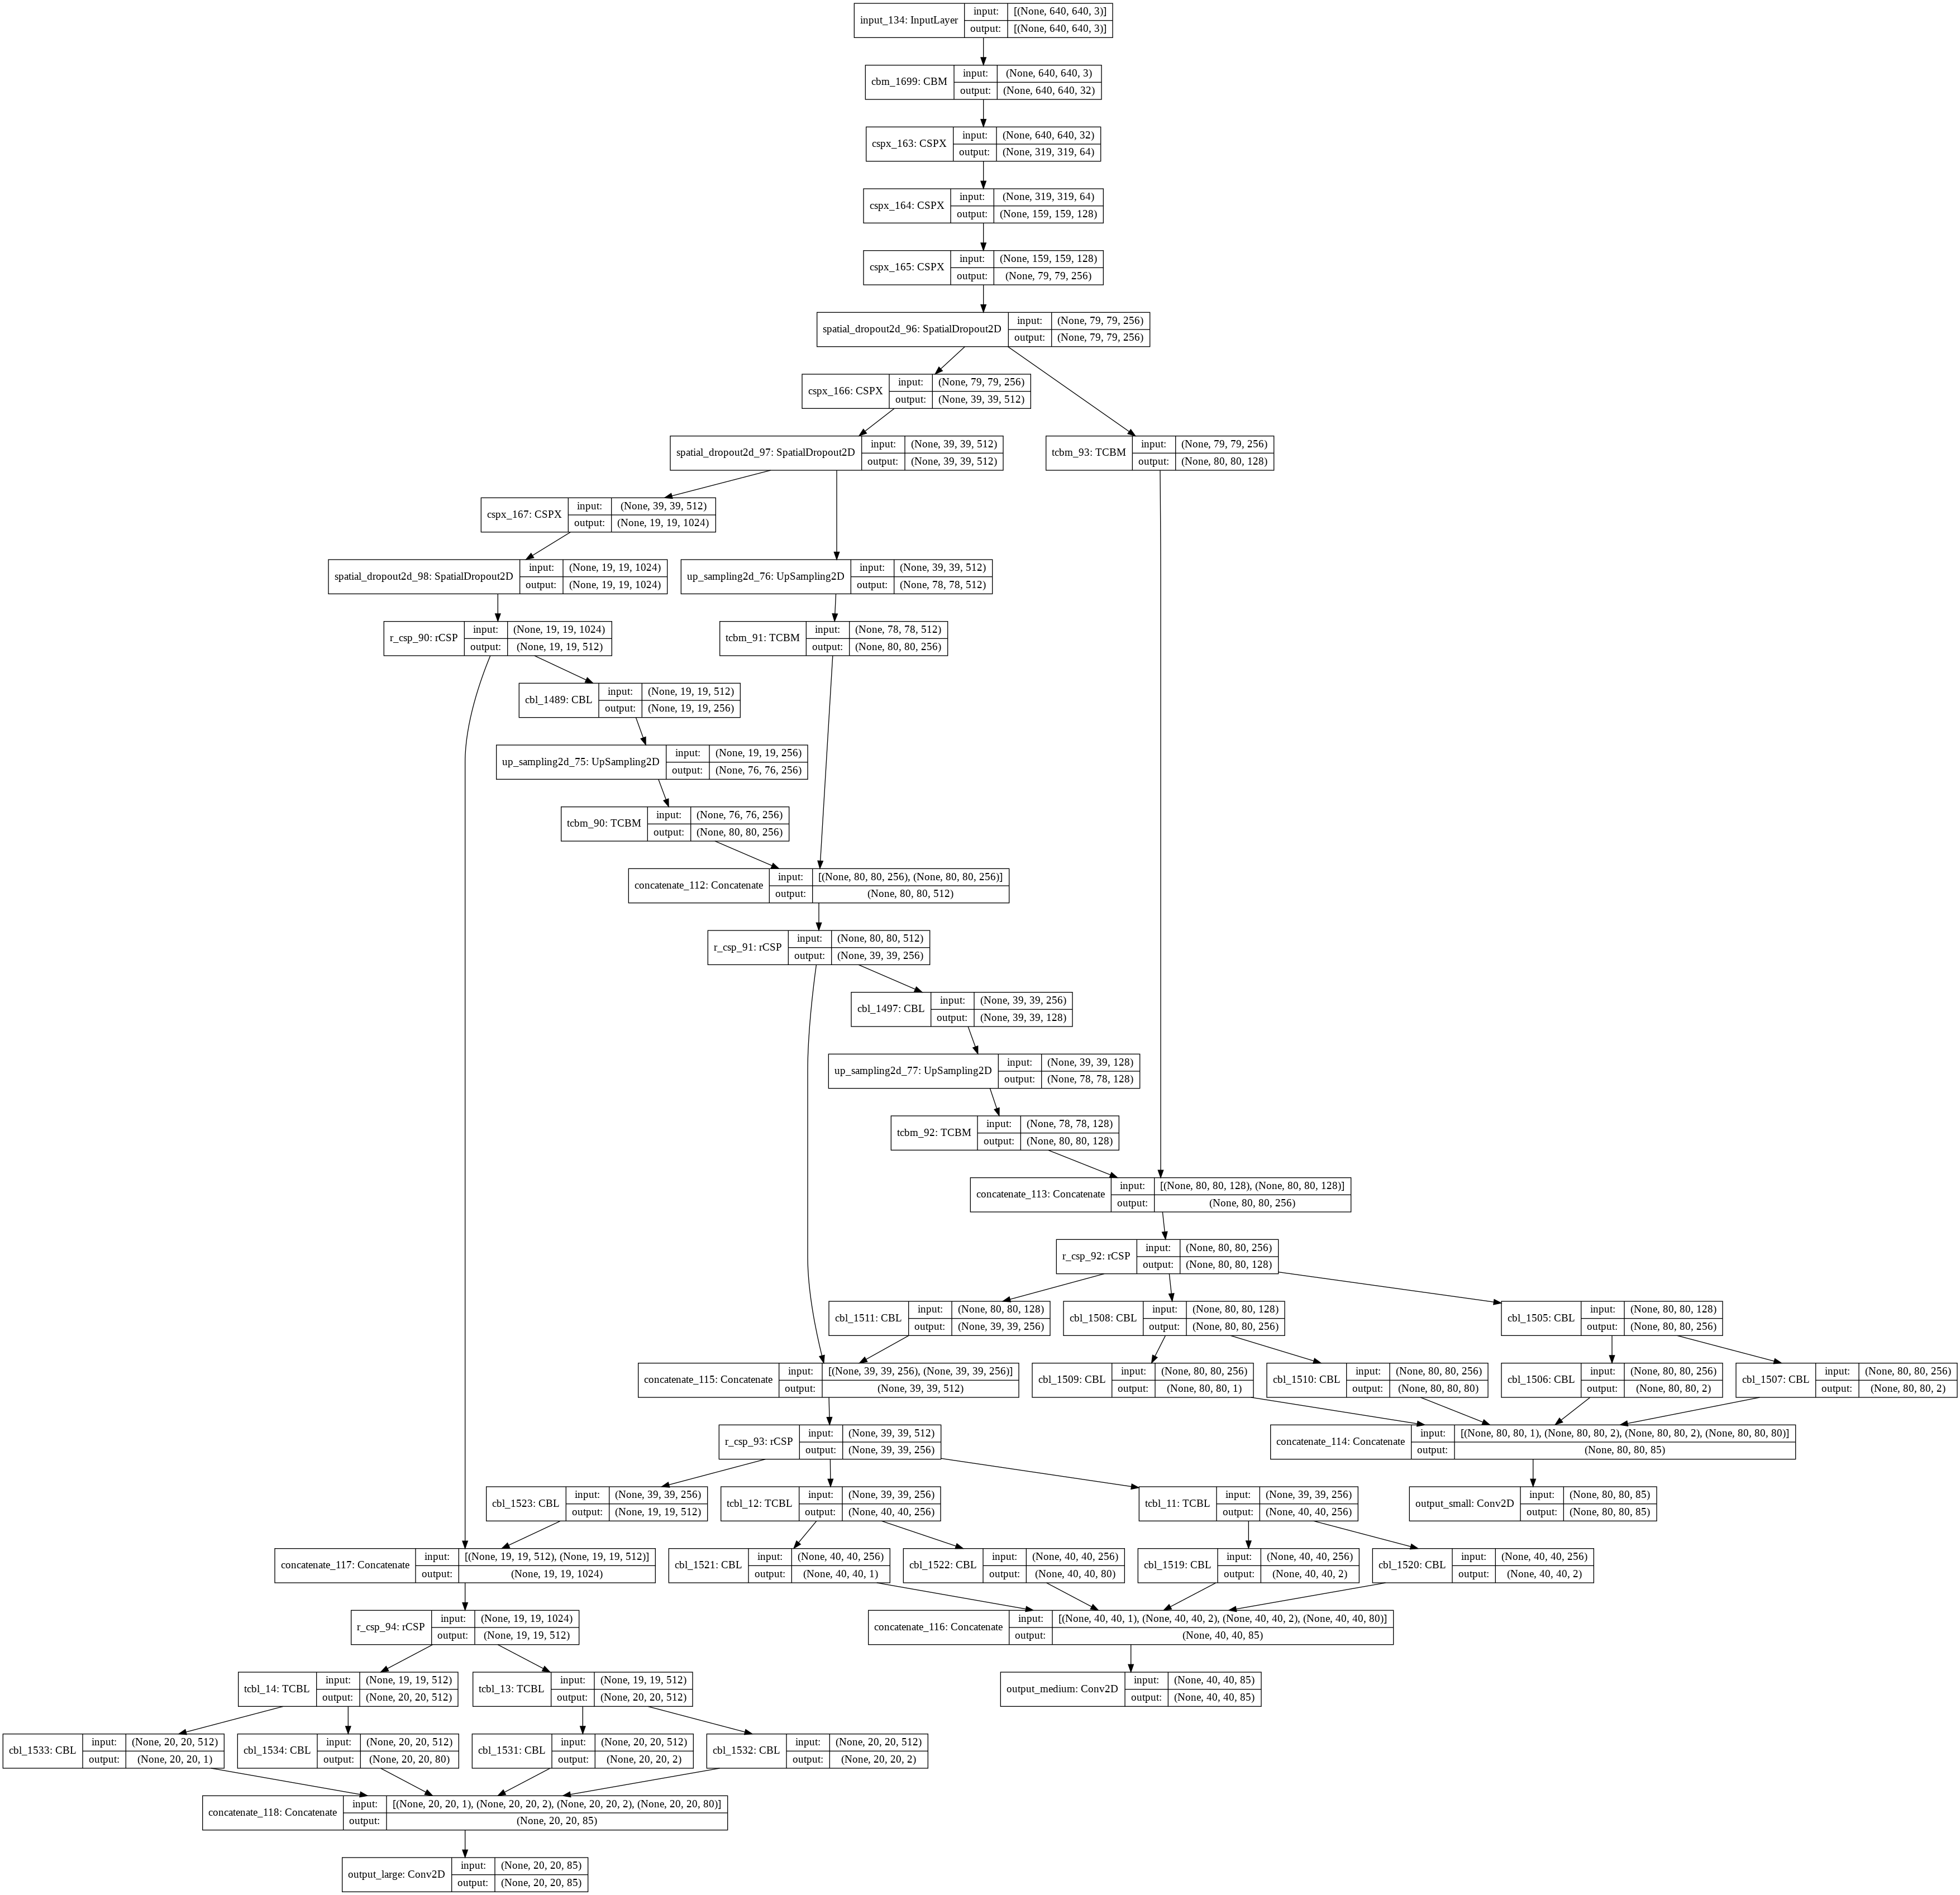

In [136]:
initializer = tf.random_normal_initializer()
k = tf.Variable(initial_value=initializer(shape=(10,640,640,3),dtype="float32"))
in_x = tf.keras.layers.Input(shape=tuple(k.get_shape().as_list()[1:]))

y = alpha_model()
model = y.graph_model(tuple(in_x.get_shape().as_list()[1:]))
plot_model(model,show_shapes=True, show_layer_names=True)

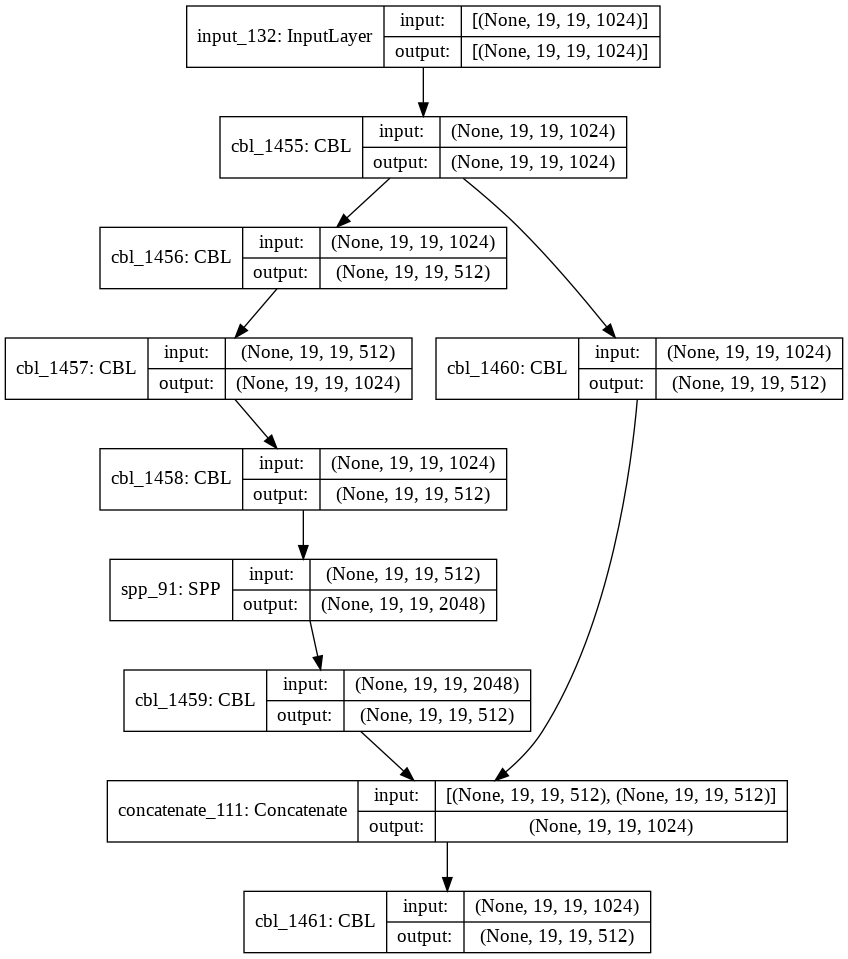

In [134]:
rCSP_info = {}

rCSP_info["CBL_1"] = (1024,3,1,"same")
rCSP_info["CBL_2"] = (512,1,1,"same")
rCSP_info["CBL_3"] = (1024,3,1,"same")
rCSP_info["CBL_4"] = (512,1,1,"same")
rCSP_info["CBL_5"] = (512,1,1,"same")
rCSP_info["CBL_6"] = (512,3,1,"same")
rCSP_info["CBL_7"] = (512,1,1,"same")



initializer = tf.random_normal_initializer()
k = tf.Variable(initial_value=initializer(shape=(10,19,19,1024),dtype="float64"))
in_x = tf.keras.layers.Input(shape=tuple(k.get_shape().as_list()[1:]))

y = rCSP(rCSP_info)
model = y.graph_model(tuple(in_x.get_shape().as_list()[1:]))
plot_model(model,show_shapes=True, show_layer_names=True)

In [94]:

res = tf.keras.layers.Lambda(Mish)(x)
print(type(res))
print(type(x))

The following Variables were used a Lambda layer's call (lambda_40), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(10, 10, 128) dtype=float64, numpy=
array([[[-0.10879914,  0.03234262, -0.0365344 , ..., -0.05126977,
          0.04198787,  0.01997681],
        [ 0.00360364,  0.02399941,  0.05573457, ..., -0.0539589 ,
          0.08637235, -0.04441165],
        [ 0.090802  ,  0.03391734, -0.01977344, ...,  0.01537586,
          0.0558676 , -0.01775612],
        ...,
        [ 0.01668491,  0.03328908, -0.03043076, ..., -0.00272903,
          0.02394113,  0.02009843],
        [-0.03845904,  0.01786051, -0.0405417 , ...,  0.02205384,
         -0.00339864,  0.01506349],
        [-0.02140627, -0.07015045, -0.03283849, ..., -0.00804136,
         -0.00492803,  0.02151024]],

       [[ 0.04673683, -0.00380198, -0.00168575, ..., -0.06632339,
          0.00348336, -0.06565897],
        [-0.04678957, -0.04223228,  0.01840654, ...,  0.03211046,
          0.04869712, 

In [95]:
x = tf.Variable([3.0,2.0,10.0])
with tf.GradientTape() as t:

  y = tf.keras.layers.Lambda(Mish)(x)

dy_dx = t.gradient(y,x)

The following Variables were used a Lambda layer's call (lambda_41), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([ 3.,  2., 10.], dtype=float32)>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


In [96]:
dy_dx

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1.0211061, 1.0693179, 1.       ], dtype=float32)>

In [97]:
k1 = tf.keras.Input(shape=(13,13,255))
k2 = tf.keras.layers.Conv2D(16,3,2)(k1)

k2[0,3:,:8,5:]

<KerasTensor: shape=(3, 6, 11) dtype=float32 (created by layer 'tf.__operators__.getitem_5')>

In [98]:
x = k1 = tf.keras.Input(shape=(13,13,255))

k1 = CBL()(x)
k2 = tf.keras.layers.Conv2D(3,2,1)(x)
print(type(k1),type(k2))

<class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'> <class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>
